# 古诗生成
本项目使用RNN进行古诗生成，使用跟彩票预测相同的思路和网络，TensorFlow2.0实现。

## LSTM介绍
我们需要从过往的历史数据中寻找规律，[`LSTM`](https://en.wikipedia.org/wiki/Long_short-term_memory)再适合不过了。如果你对LSTM不熟悉的话，以下几篇文章建议你阅读：

[`Understanding LSTM Networks`](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[`[译] 理解 LSTM 网络`](http://www.jianshu.com/p/9dc9f41f0b29)

[`RNN以及LSTM的介绍和公式梳理`](http://blog.csdn.net/Dark_Scope/article/details/47056361)


## 加载数据集

In [1]:
data_dir = './data/newtxt.txt'  # new_poetry
text = open(data_dir, 'rb').read().decode(encoding='utf-8')

下面函数是用来处理初始数据集poetry.txt的，使用newtxt.txt可以不调用。

In [2]:
import os
import re
pattern = '[a-zA-Z0-9’"#$%&\'()*+-./:;<=>@★…【】《》“”‘’[\\]^_`{|}~]+'

def preprocess_poetry(outdir, datadir):
    with open(os.path.join(outdir, 'new_poetry.txt'), 'w') as out_f:
        with open(os.path.join(datadir, 'poetry.txt'), 'r') as f:
            for line in f:
                content = line.strip().rstrip('\n').split(':')[1]  # .rstrip('\n').
                content = content.replace(' ','')
                if '】' in content or '_' in content or '(' in content or '（' in content or '《' in content or '[' in content:
                    continue
                if len(content) < 20:
                    continue
                content=re.sub(pattern, '', content)
                out_f.write(content + '\n')

In [3]:
preprocess_poetry('./data/', './data/')

## 预测网络介绍

网络的输入是每一个汉字，总共有1020个字，用one hot编码是一个1020维的稀疏向量。

使用one hot稀疏向量在输入层与网络第一层做矩阵乘法时会很没有效率，因为向量里面大部分都是0， 矩阵乘法浪费了大量的计算，最终矩阵运算得出的结果是向量中值为1的列所对应的矩阵中的行向量。
<img src="assets/lookup_matrix.png">

这看起来很像用索引查表一样，one hot向量中值为1的位置作为下标，去索引参数矩阵中的行向量。

为了代替矩阵乘法，我们将参数矩阵当作一个查找表（lookup table）或者叫做嵌入矩阵（embedding matrix），使用每个汉字所对应索引，比如汉字“你”，索引是958，然后在查找表中找第958行。

这其实跟替换之前的模型没有什么不同，嵌入矩阵就是参数矩阵，嵌入层仍然是隐层。查找表只是矩阵乘法的一种便捷方式，它会像参数矩阵一样被训练，是要学习的参数。

下面就是我们要构建的网络架构，从嵌入层输出的向量进入LSTM层进行时间序列的学习，然后经过softmax预测出下一个汉字。

## 编码实现

### 实现数据预处理

我们需要先准备好汉字和ID之间的转换关系。在这个函数中，创建并返回两个字典：
- 汉字到ID的转换字典： `vocab_to_int`
- ID到汉字的转换字典： `int_to_vocab`


In [6]:
import numpy as np
from collections import Counter
import pickle

def create_lookup_tables():

    vocab = sorted(set(text))
    vocab_to_int = {u:i for i, u in enumerate(vocab)}
    int_to_vocab = np.array(vocab)
    
    int_text = np.array([vocab_to_int[word] for word in text if word != '\n'])

    pickle.dump((int_text, vocab_to_int, int_to_vocab), open('preprocess.p', 'wb'))


### 处理所有数据并保存
将每期结果按照从第一期开始的顺序保存到文件中。

In [7]:
create_lookup_tables()

In [9]:
import numpy as np
# 读取保存的数据
int_text, vocab_to_int, int_to_vocab = pickle.load(open('preprocess.p', mode='rb'))

In [10]:
def get_batches(int_text, batch_size, seq_length):

    batchCnt = len(int_text) // (batch_size * seq_length)
    int_text_inputs = int_text[:batchCnt * (batch_size * seq_length)]
    int_text_targets = int_text[1:batchCnt * (batch_size * seq_length)+1]

    result_list = []
    x = np.array(int_text_inputs).reshape(1, batch_size, -1)
    y = np.array(int_text_targets).reshape(1, batch_size, -1)

    x_new = np.dsplit(x, batchCnt)
    y_new = np.dsplit(y, batchCnt)

    for ii in range(batchCnt):
        x_list = []
        x_list.append(x_new[ii][0])
        x_list.append(y_new[ii][0])
        result_list.append(x_list)

    return np.array(result_list)


## 训练神经网络
### 超参数


In [11]:
vocab_size = len(int_to_vocab)

# 批次大小
batch_size = 32  # 64
# RNN的大小（隐藏节点的维度）
rnn_size = 1000
# 嵌入层的维度
embed_dim = 256  # 这里做了调整，跟彩票预测的也不同了
# 序列的长度
seq_length = 15  # 注意这里已经不是1了，在古诗预测里面这个数值可以大一些，比如100也可以的

save_dir = './save'

### 构建计算图
使用实现的神经网络构建计算图。

In [12]:
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time

MODEL_DIR = "./poetry_models"

train_batches = get_batches(int_text, batch_size, seq_length)  
losses = {'train': [], 'test': []}


class poetry_network(object):
    def __init__(self, batch_size=32):
        self.batch_size = batch_size  
        self.best_loss = 9999

        self.model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embed_dim,
                                      batch_input_shape=[batch_size, None]),
            tf.keras.layers.LSTM(rnn_size,
                                 return_sequences=True,
                                 stateful=True,
                                 recurrent_initializer='glorot_uniform'),
            tf.keras.layers.Dense(vocab_size)
        ])
        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam()
        self.ComputeLoss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        if tf.io.gfile.exists(MODEL_DIR):
            #             print('Removing existing model dir: {}'.format(MODEL_DIR))
            #             tf.io.gfile.rmtree(MODEL_DIR)
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')

        self.train_summary_writer = summary_ops_v2.create_file_writer(train_dir, flush_millis=10000)
 
        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    @tf.function
    def train_step(self, x, y):
        # Record the operations used to compute the loss, so that the gradient
        # of the loss with respect to the variables can be computed.

        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)

            loss = self.ComputeLoss(y, logits)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, epochs=1, log_freq=50):

        batchCnt = len(int_text) // (batch_size * seq_length)
        print("batchCnt : ", batchCnt)
        for i in range(epochs):
            train_start = time.time()
            with self.train_summary_writer.as_default():
                start = time.time()
                # Metrics are stateful. They accumulate values and return a cumulative
                # result when you call .result(). Clear accumulated values with .reset_states()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

                # Datasets can be iterated over like any other Python iterable.
                for batch_i, (x, y) in enumerate(train_batches):
                    loss, logits = self.train_step(x, y)
                    avg_loss(loss)
                    losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        summary_ops_v2.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)

                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tLoss: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(), loss, rate))

                        avg_loss.reset_states()

                        start = time.time()
#                         self.checkpoint.save(self.checkpoint_prefix)
            self.checkpoint.save(self.checkpoint_prefix)
            print("save model\n")


## 训练
在预处理过的数据上训练神经网络。 

In [13]:
net = poetry_network()
net.training(20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           932352    
_________________________________________________________________
lstm (LSTM)                  (32, None, 1000)          5028000   
_________________________________________________________________
dense (Dense)                (32, None, 3642)          3645642   
Total params: 9,605,994
Trainable params: 9,605,994
Non-trainable params: 0
_________________________________________________________________
batchCnt :  161
Step #50	Loss: 6.623273 (1.4579346911925 steps/sec)
Step #100	Loss: 6.618058 (1.760274296160389 steps/sec)
Step #150	Loss: 6.762348 (1.7745142395123255 steps/sec)
save model

Step #200	Loss: 6.397208 (2.2850820118818485 steps/sec)
Step #250	Loss: 6.251562 (1.8047937182515517 steps/sec)
Step #300	Loss: 6.305763 (1.789508945441332 steps/sec)
save model

Step #

## 显示训练Loss

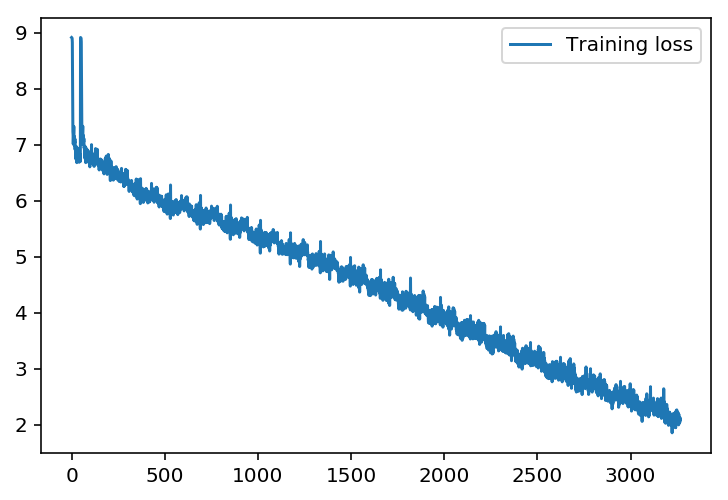

In [80]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 加载保存的模型，准备预测

In [14]:
restore_net=poetry_network(1)
restore_net.model.build(tf.TensorShape([1, None]))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            932352    
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1000)           5028000   
_________________________________________________________________
dense_1 (Dense)              (1, None, 3642)           3645642   
Total params: 9,605,994
Trainable params: 9,605,994
Non-trainable params: 0
_________________________________________________________________


## 生成古诗
开始生成古诗了。
 - `prime_word` 是开始的头一个字。
 - `top_n` 从前N个候选汉字中随机选择
 - `rule` 默认是7言绝句
 - `sentence_lines` 生成几句古诗，默认是4句（，和。都算一句）
 - `hidden_head` 藏头诗的前几个字

In [15]:
def gen_poetry(prime_word='白', top_n=5, rule=7, sentence_lines=4, hidden_head=None):
    gen_length = sentence_lines * (rule + 1) - len(prime_word)
    gen_sentences = [prime_word] if hidden_head==None else [hidden_head[0]]
    temperature = 1.0

    dyn_input = [vocab_to_int[s] for s in prime_word]
    dyn_input = tf.expand_dims(dyn_input, 0)

    dyn_seq_length = len(dyn_input[0])

    restore_net.model.reset_states()
    index=len(prime_word) if hidden_head==None else 1
    for n in range(gen_length):

        index += 1
        predictions = restore_net.model(np.array(dyn_input))
        
        predictions = tf.squeeze(predictions, 0)

        if index!=0 and (index % (rule+1)) == 0:
            if ((index / (rule+1)) + 1) % 2 == 0:
                predicted_id=vocab_to_int['，']
            else:
                predicted_id=vocab_to_int['。']
        else:
            if hidden_head != None and (index-1)%(rule+1)==0 and (index-1)//(rule+1) < len(hidden_head):
                predicted_id=vocab_to_int[hidden_head[(index-1)//(rule+1)]]
            else:
                while True:
                    predictions = predictions / temperature
                    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

                    # p = np.squeeze(predictions[-1].numpy())
                    # p[np.argsort(p)[:-top_n]] = 0
                    # p = p / np.sum(p)
                    # c = np.random.choice(vocab_size, 1, p=p)[0]
                    # predicted_id=c
                    if(predicted_id != vocab_to_int['，'] and predicted_id != vocab_to_int['。'] ):
                        break
    # using a multinomial distribution to predict the word returned by the model
    #         predictions = predictions / temperature
    #         predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()

        dyn_input = tf.expand_dims([predicted_id], 0)
        gen_sentences.append(int_to_vocab[predicted_id])

    poetry_script = ' '.join(gen_sentences)
    poetry_script = poetry_script.replace('\n ', '\n')
    poetry_script = poetry_script.replace('( ', '(')

    return poetry_script

## 给定开头

In [14]:
gen_poetry(prime_word='白日依山尽', top_n=10, rule=5, sentence_lines=4)

'白日依山尽 ， 照 岸 终 年 矜 。 目 尽 飞 猿 笑 ， 愁 长 断 独 声 。'

## 7言绝句

In [168]:
gen_poetry(prime_word='春', top_n=10, rule=7, sentence_lines=4)

'春 至 处 马 上 长 杨 ， 谁 家 窈 窕 九 重 闺 。 秦 国 陇 台 汉 边 风 ， 日 照 胡 沙 尘 花 中 。'

## 5言

In [198]:
gen_poetry(prime_word='月', top_n=10, rule=5, sentence_lines=4)

'月 来 长 河 闭 ， 苔 疏 连 叶 满 。 归 来 入 汉 使 ， 居 带 天 门 台 。'

## 藏头诗

In [192]:
gen_poetry(prime_word='夏', top_n=10, rule=7, sentence_lines=4, hidden_head='花好月圆')

'花裛茗蹙蕣觜聂，好嚬偷逮嚬鲤蜘。月擐拖鸷标拖鸷，圆偷选偷袄鸷蕣。'

# 结论

使用原始的数据集训练太慢了，我只使用了前1000行的古诗训练，训练次数也不太多，可以继续训练再试试。

今天的分享就到这里，大家洗洗睡吧 ：）